In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils, pickle, bz2
reload(mlutils)
%matplotlib inline

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [4]:
!ls -lash data/alexnet_conv1_conv2.pklz

1,4M -rw-rw-r-- 1 julian julian 1,4M abr  9 08:10 data/alexnet_conv1_conv2.pklz


In [5]:
alex_c12 = pickle.load(bz2.BZ2File("data/alexnet_conv1_conv2.pklz", "r"))
for k,(w,b) in alex_c12.iteritems():
    print k, b.shape, w.shape

conv2 (256,) (5, 5, 48, 256)
conv1 (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


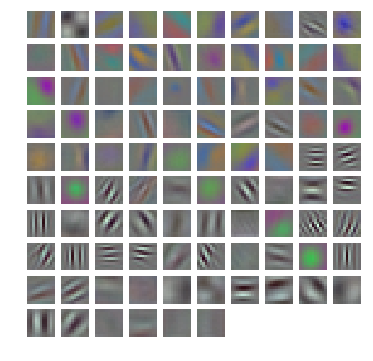

In [6]:
alex_w1 = alex_c12["conv1"][0]
print alex_w1.shape
mlutils.display_imgs(alex_w1)


### Vamos a usarlos como punto de partida para el entrenamiento de nuestra red

In [7]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

--2019-06-04 19:02:42--  https://s3.amazonaws.com/rlx/mini_cifar.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.112.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.112.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14803609 (14M) [binary/octet-stream]
Saving to: ‘mini_cifar.h5’

mini_cifar.h5       100%[===================>]  14,12M  2,03MB/s    in 6,8s    

2019-06-04 19:02:49 (2,09 MB/s) - ‘mini_cifar.h5’ saved [14803609/14803609]



In [8]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

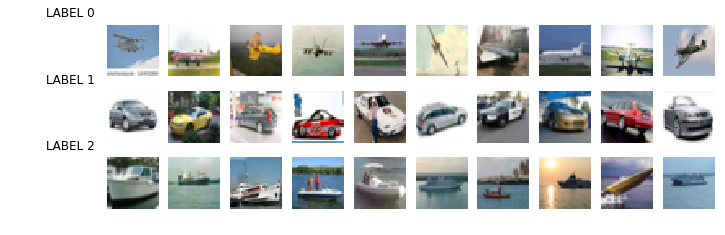

In [9]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    780
0    747
1    726
dtype: int64

distribution of test classes
0    258
1    248
2    245
dtype: int64


In [11]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [12]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}



In [13]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

using 3 classes
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropo

## Transfer learning!!!

- Importamos el valor de los filtros de primer nivel


In [14]:
w = model.get_weights()
for i in w:
    print i.shape

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


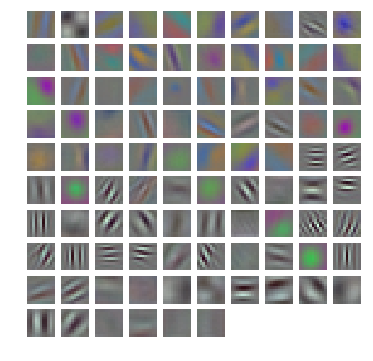

In [15]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [16]:
model.set_weights(w)

In [17]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 10s 5ms/sample - loss: 1.0697 - acc: 0.4749 - val_loss: 0.8936 - val_acc: 0.6365
Epoch 2/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.9315 - acc: 0.5730 - val_loss: 0.8466 - val_acc: 0.6525
Epoch 3/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.8587 - acc: 0.6298 - val_loss: 0.7983 - val_acc: 0.6498
Epoch 4/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.8202 - acc: 0.6516 - val_loss: 0.8344 - val_acc: 0.6285
Epoch 5/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.7439 - acc: 0.6889 - val_loss: 0.6734 - val_acc: 0.7377
Epoch 6/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.7076 - acc: 0.7155 - val_loss: 0.7346 - val_acc: 0.6764
Epoch 7/15
2253/2253 [==============================] - 10s 4ms/sample - loss: 0.6590 - acc: 0.7412 - val_loss: 0.6523 - val_acc: 0.7550

{'acc': 0.7443409, 'loss': 0.6955877002006206}

Normalized confusion matrix
[[0.64728682 0.07751938 0.2751938 ]
 [0.10887097 0.72580645 0.16532258]
 [0.08163265 0.05306122 0.86530612]]


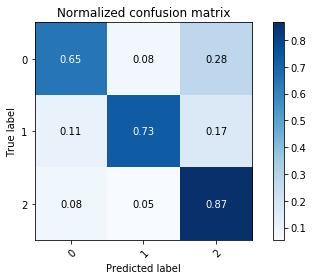

In [18]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

observa que los filtros de primer nivel cambiaron, pero muy poco

In [19]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.020788155

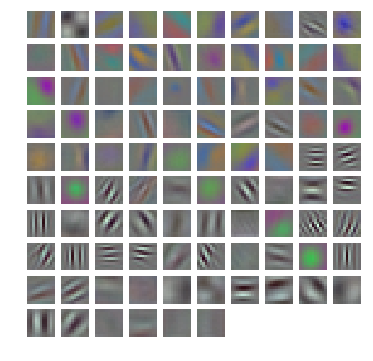

In [20]:
mlutils.display_imgs(w[0])

In [39]:
model.save("alexnet_finetuned_minicifar.model")

observe that you can also save separately the architecture

In [40]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [41]:
!ls -lash alexnet_finetuned_minicifar*

8,0K -rw-rw-r-- 1 rlx rlx 3,6K mar 10 18:09 alexnet_finetuned_minicifar.architecture.json
8,5M -rw-rw-r-- 1 rlx rlx 8,5M mar 10 18:09 alexnet_finetuned_minicifar.model


In [21]:
!head alexnet_finetuned_minicifar.architecture.json

{"class_name": "Model", "keras_version": "2.1.6-tf", "config": {"layers": [{"class_name": "InputLayer", "config": {"dtype": "float32", "batch_input_shape": [null, 32, 32, 3], "name": "input_1", "sparse": false}, "inbound_nodes": [], "name": "input_1"}, {"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "GlorotUniform", "config": {"dtype": "float32", "seed": null}}, "name": "conv2d", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "data_format": "channels_last", "padding": "valid", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "filters": 96, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "use_bias": true, "activity_regularizer": null, "kernel_size": [11, 11]}, "inbound_nodes": [[["input_1", 0, 0, {}]]], "name": "conv2d"}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "dtype": "float32", "trainable": 

## Using pretrained models in keras

In [59]:
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, Flatten
model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(32,32,3), pooling=None)

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [61]:
for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.layers[-1].output)
x = Dense(3,activation='softmax')(x)


In [62]:
model2 = Model(input=[model.layers[0].input],outputs=[x])

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [63]:
model2.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
model2.fit(x_train, y_train, batch_size=16, epochs=15, validation_data=(x_test, y_test))

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 32s 14ms/step - loss: 0.9392 - acc: 0.5566 - val_loss: 0.8151 - val_acc: 0.6738
Epoch 2/15
2253/2253 [==============================] - 31s 14ms/step - loss: 0.7832 - acc: 0.6804 - val_loss: 0.7688 - val_acc: 0.6738
Epoch 3/15
2253/2253 [==============================] - 34s 15ms/step - loss: 0.7242 - acc: 0.7079 - val_loss: 0.6903 - val_acc: 0.7430
Epoch 4/15
2253/2253 [==============================] - 31s 14ms/step - loss: 0.6836 - acc: 0.7324 - val_loss: 0.6685 - val_acc: 0.7430
Epoch 5/15
2253/2253 [==============================] - 31s 14ms/step - loss: 0.6549 - acc: 0.7390 - val_loss: 0.6591 - val_acc: 0.7403
Epoch 6/15
2253/2253 [==============================] - 30s 13ms/step - loss: 0.6369 - acc: 0.7452 - val_loss: 0.6308 - val_acc: 0.7656
Epoch 7/15
2253/2253 [==============================] - 33s 15ms/step - loss: 0.6213 - acc: 0.7523 - val_loss: 0.6137 - val_acc: 0.7736
E

Normalized confusion matrix
[[0.79844961 0.07751938 0.12403101]
 [0.08064516 0.81854839 0.10080645]
 [0.15102041 0.11428571 0.73469388]]


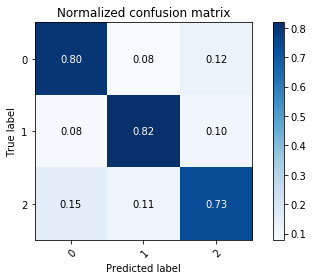

In [66]:
test_preds = model2.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

In [67]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [68]:
for _ in range(3):
    model2.layers.pop()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

/home/julian/.local/lib/python2.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
